# Begin Imports

In [1]:
## Made with reference to https://medium.com/swlh/using-xlnet-for-sentiment-classification-cfa948e65e85
import transformers
from transformers import XLNetTokenizer, XLNetModel, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.utils import shuffle
from collections import defaultdict
from textwrap import wrap
from pylab import rcParams
import re

from torch import nn, optim
from keras_preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset,RandomSampler,SequentialSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F






#### Assign Random Seed and add GPU to pytorch

In [2]:
RANDOM_SEED = 69
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Begin Importing of training dataset

In [4]:
# Reading data using pandas
path_to_data = "Crypto_Sentiment_Dataset.csv"
df = pd.read_csv(path_to_data, encoding = 'raw_unicode_escape', engine ='python',header = None)

# Shuffle and Clip data
df = shuffle(df)
#df = df[:20000]

# Function to clean text. Remove tagged entities, hyperlinks, emojis
def clean_text(text):
    text = re.sub(r"@[A-Za-z0-9]+", ' ', text)
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    text = re.sub(r"[^a-zA-z.!?'0-9]", ' ', text)
    text = re.sub('\t', ' ',  text)
    text = re.sub(r" +", ' ', text)
    return text
 
df['tweet'] = df[3].apply(clean_text)

# Function to convert labels to number.
def sentiment2label(sentiment):
    if sentiment == "Positive":
        return 1
    else :
        return 0

df['sentiment'] = df[4].apply(sentiment2label)

# List of class names.
class_names = ['negative', 'positive']

#### Checking data is as expected

In [5]:
df['sentiment'].value_counts()

1    302
0    261
Name: sentiment, dtype: int64

In [6]:
print(len(df))
df.head(5)

563


,0,1,2,3,4,5,tweet,sentiment
343,QQYCQPQK6WFA,false,NaN,Cryptocurrency is bad for the environment beca...,Negative,https://www.reddit.com/r/explainlikeimfive/com...,Cryptocurrency is bad for the environment beca...,0
381,ADCXHGCQRA34,false,NaN,It's great to get paid for heating a swimming ...,Positive,https://www.reddit.com/r/Bitcoin/comments/uzzp...,It's great to get paid for heating a swimming ...,1
135,WYWGJAYCCA6D,false,NaN,"This is the way. Until the ride back up, go ou...",Positive,https://www.reddit.com/r/Bitcoin/comments/ul5y...,This is the way. Until the ride back up go out...,1
222,AQDRYYFGDJJ7,false,NaN,I donât have the money to invest in it but I...,Positive,https://www.reddit.com/r/AskWomen/comments/s36...,I don t have the money to invest in it but I d...,1
20,TD36G7T2EZEK,false,NaN,"Literally crashing to zero in real time atm, L...",Negative,https://old.reddit.com/r/terraluna/comments/un...,Literally crashing to zero in real time atm Lu...,0


## Importing a pretrained XLNET model

In [7]:
from transformers import XLNetTokenizer, XLNetModel
PRE_TRAINED_MODEL_NAME = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

In [8]:
from transformers import XLNetForSequenceClassification
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels = 2)
model = model.to(device)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [9]:
model

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward

## Creating the dataset and dataloader for the training model

In [10]:
class tweetDataset(Dataset):

    def __init__(self, tweets, targets, tokenizer, max_len):
        self.tweets = tweets
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.tweets)
    
    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
        tweet,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=False,
        return_attention_mask=True,
        return_tensors='pt',
        )

        input_ids = pad_sequences(encoding['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        input_ids = input_ids.astype(dtype = 'int64')
        input_ids = torch.tensor(input_ids) 

        attention_mask = pad_sequences(encoding['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        attention_mask = attention_mask.astype(dtype = 'int64')
        attention_mask = torch.tensor(attention_mask)       

        return {
        'tweet': tweet,
        'input_ids': input_ids,
        'attention_mask': attention_mask.flatten(),
        'targets': torch.tensor(target, dtype=torch.long)
        }

In [11]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = tweetDataset(
    tweets=df.tweet.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=0
  )

#### Splitting the training dataset into 3 categories, one half to train the model and one quarter to evaluate and then test the model

In [12]:
df_train, df_test = train_test_split(df, test_size=0.5, random_state=101)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=101)
df_train.shape, df_val.shape, df_test.shape

((281, 8), (141, 8), (141, 8))

In [13]:
BATCH_SIZE = 8
MAX_LEN = 128
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [14]:
data = next(iter(val_data_loader))
data.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['tweet', 'input_ids', 'attention_mask', 'targets'])

### Adding the hyperparemeters and number of epochs

In [15]:
EPOCHS = 15

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
                                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}
]
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=3e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

#### Assigning inputs, masks, targets and outputs

In [16]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
targets = data['targets'].to(device)
print(input_ids.shape)

torch.Size([8, 1, 128])


In [17]:
print(input_ids.reshape(BATCH_SIZE,MAX_LEN).shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 128])
torch.Size([8, 128])


In [18]:
outputs = model(input_ids.reshape(BATCH_SIZE,MAX_LEN), token_type_ids=None, attention_mask=attention_mask, labels=targets)
outputs

XLNetForSequenceClassificationOutput(loss=tensor(0.9212, device='cuda:0', grad_fn=<NllLossBackward0>), logits=tensor([[ 0.0163,  0.1820],
        [ 0.3078, -0.1199],
        [ 0.3476, -0.1450],
        [ 0.6111, -0.0026],
        [ 0.4587, -0.0722],
        [ 0.3216, -0.0561],
        [ 0.3525, -0.1678],
        [ 0.5471,  0.1180]], device='cuda:0', grad_fn=<AddmmBackward0>), mems=(tensor([[[ 0.0372,  0.0792, -0.0861,  ...,  0.0489,  0.0098, -0.0162],
         [-0.0179, -0.0364, -0.0415,  ...,  0.0125,  0.0062,  0.0325],
         [ 0.0415, -0.0492, -0.0154,  ..., -0.0751, -0.0746, -0.0578],
         ...,
         [ 0.0562, -0.0064,  0.0377,  ..., -0.0530,  0.0443, -0.0394],
         [-0.0450,  0.1279,  0.0265,  ..., -0.0218,  0.0323, -0.0202],
         [ 0.0415, -0.0492, -0.0154,  ..., -0.0751, -0.0746, -0.0578]],

        [[-0.0482, -0.0126,  0.0453,  ..., -0.0780, -0.0425,  0.0127],
         [-0.0004, -0.0517,  0.0827,  ...,  0.0242,  0.0469,  0.0494],
         [-0.0293,  0.0233,  0.

## Defining the training model and evaluation model

In [19]:
from sklearn import metrics
def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    acc = 0
    counter = 0
  
    for d in data_loader:
        if str(d["input_ids"].shape) == "torch.Size([8, 1, 128])":

            input_ids = d["input_ids"].reshape(8,128).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
            loss = outputs[0]
            logits = outputs[1]

            _, prediction = torch.max(outputs[1], dim=1)
            targets = targets.cpu().detach().numpy()
            prediction = prediction.cpu().detach().numpy()
            accuracy = metrics.accuracy_score(targets, prediction)

            acc += accuracy
            losses.append(loss.item())

            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            counter = counter + 1

    return acc / counter, np.mean(losses)

In [20]:

def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    acc = 0
    counter = 0
  
    with torch.no_grad():
        for d in data_loader:
            #print(d["input_ids"])
            #print(d["input_ids"].shape)
            if str(d["input_ids"].shape) == "torch.Size([8, 1, 128])":
                #print("correctSize")
                input_ids = d["input_ids"].reshape(8,128).to(device)
                attention_mask = d["attention_mask"].to(device)
                targets = d["targets"].to(device)

                outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
                loss = outputs[0]
                logits = outputs[1]

                _, prediction = torch.max(outputs[1], dim=1)
                targets = targets.cpu().detach().numpy()
                prediction = prediction.cpu().detach().numpy()
                accuracy = metrics.accuracy_score(targets, prediction)

                acc += accuracy
                losses.append(loss.item())
                counter += 1
            

    return acc / counter, np.mean(losses)

# Training the model
-----------------------------------

In [21]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,     
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
    )

    print(f'Train loss {train_loss} Train accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader, 
        device, 
        len(df_val)
    )

    print(f'Val loss {val_loss} Val accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'xlnet_model.bin')
        best_accuracy = val_acc

Epoch 1/15
----------
Train loss 0.7141569546290807 Train accuracy 0.5464285714285714
Val loss 0.6691978643922245 Val accuracy 0.5514705882352942

Epoch 2/15
----------
Train loss 0.6421558618545532 Train accuracy 0.6035714285714285
Val loss 0.42644208669662476 Val accuracy 0.7941176470588235

Epoch 3/15
----------
Train loss 0.41001503611249585 Train accuracy 0.825
Val loss 0.43811540979453745 Val accuracy 0.8602941176470589

Epoch 4/15
----------
Train loss 0.2036346177836614 Train accuracy 0.9357142857142857
Val loss 0.6165330481667565 Val accuracy 0.875

Epoch 5/15
----------
Train loss 0.30995242827505404 Train accuracy 0.95
Val loss 0.5332574247800307 Val accuracy 0.9044117647058824

Epoch 6/15
----------
Train loss 0.1311382585097038 Train accuracy 0.9571428571428572
Val loss 0.49455608805446366 Val accuracy 0.9117647058823529

Epoch 7/15
----------
Train loss 0.011622533692778754 Train accuracy 0.9928571428571429
Val loss 0.6613543384532129 Val accuracy 0.9264705882352942

Epoc

# Using the trained Model
---------------------------------------------

In [22]:
model.load_state_dict(torch.load('xlnet_model.bin'))

<All keys matched successfully>

#### Testing the model on the training data

In [23]:
model = model.to(device)
test_acc, test_loss = eval_model(
  model,
  test_data_loader,
  device,
  len(df_test)
)

print('Test Accuracy :', test_acc)
print('Test Loss :', test_loss)

Test Accuracy : 0.875
Test Loss : 0.9412999047182145


In [24]:
def get_predictions(model, data_loader):
    model = model.eval()
    
    tweets = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            if str(d["input_ids"].shape) == "torch.Size([8, 1, 128])":


                tweets = d["tweet"]
                input_ids = d["input_ids"].reshape(8,128).to(device)
                attention_mask = d["attention_mask"].to(device)
                targets = d["targets"].to(device)

                outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)

                loss = outputs[0]
                logits = outputs[1]

                _, preds = torch.max(outputs[1], dim=1)

                probs = F.softmax(outputs[1], dim=1)

                tweets.extend(tweets)
                predictions.extend(preds)
                prediction_probs.extend(probs)
                real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return tweets, predictions, prediction_probs, real_values

In [25]:
y_tweet, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

              precision    recall  f1-score   support

    negative       0.86      0.88      0.87        65
    positive       0.89      0.87      0.88        71

    accuracy                           0.88       136
   macro avg       0.87      0.88      0.87       136
weighted avg       0.88      0.88      0.88       136



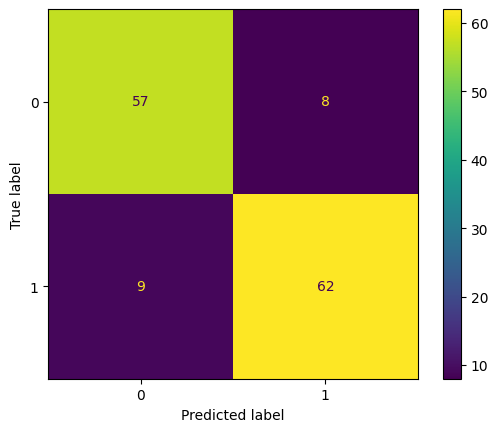

In [26]:
print(classification_report(y_test, y_pred, target_names=class_names))
cm = confusion_matrix(y_test,y_pred)
ConfusionMatrixDisplay(cm).plot()

# Defining a function that will run the model on a single statement

In [27]:

def predict_sentiment(text):
    tweet = text

    encoded_tweet = tokenizer.encode_plus(
    tweet,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=False,
    return_attention_mask=True,
    return_tensors='pt',
    )

    input_ids = pad_sequences(encoded_tweet['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
    input_ids = input_ids.astype(dtype = 'int64')
    input_ids = torch.tensor(input_ids) 

    attention_mask = pad_sequences(encoded_tweet['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
    attention_mask = attention_mask.astype(dtype = 'int64')
    attention_mask = torch.tensor(attention_mask) 

    input_ids = input_ids.reshape(1,128).to(device)
    attention_mask = attention_mask.to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    outputs = outputs[0][0].cpu().detach()

    probs = F.softmax(outputs, dim=-1).cpu().detach().numpy().tolist()
    _, prediction = torch.max(outputs, dim =-1)

    print("Positive score:", probs[1])
    print("Negative score:", probs[0])
    print(f'tweet: {tweet}')
    print(f'Sentiment  : {class_names[prediction]}')

In [28]:
text = "Bitcoin is so in right now"
predict_sentiment(text)

Positive score: 0.9999788999557495
Negative score: 2.108891749230679e-05
tweet: Bitcoin is so in right now
Sentiment  : positive


# Loading in a larger test file

In [29]:
# Reading data using pandas
path_to_data = "bitcoin_tweets1000000.csv"
dfBitcoin = pd.read_csv(path_to_data, encoding = 'latin', engine ='c')

# Shuffle and Clip data as we dont need to test on the whole 10000000 lines
dfBitcoin = shuffle(dfBitcoin)
dfBitcoin = dfBitcoin.dropna(subset=['text','sentiment'])

dfBitcoin['sentiment'] = dfBitcoin['sentiment'].astype(int)

dfBitcoin = dfBitcoin[:10000]



C:\Users\drago\AppData\Local\Temp\ipykernel_19692\2343067571.py:3: DtypeWarning: Columns (0,5,6,7,8,13) have mixed types. Specify dtype option on import or set low_memory=False.
  dfBitcoin = pd.read_csv(path_to_data, encoding = 'latin', engine ='c')


In [30]:
# Function to clean text. Remove tagged entities, hyperlinks, emojis
def clean_text(text):
    text = re.sub(r"@[A-Za-z0-9]+", ' ', str(text))
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', str(text))
    text = re.sub(r"[^a-zA-z.!?'0-9]", ' ', str(text))
    text = re.sub('\t', ' ',  str(text))
    text = re.sub(r" +", ' ', str(text))
    return text
 
dfBitcoin['text'] = dfBitcoin['text'].apply(clean_text)


In [31]:
dfBitcoin['sentiment'].value_counts()

0    5282
1    4718
Name: sentiment, dtype: int64

### Testing manually

In [32]:
i = 1
import time
for text in dfBitcoin['text']:
    if i <100 :
        predict_sentiment(text)
        print("-------------------------------------\n")
        i = i+1

Positive score: 0.08615074306726456
Negative score: 0.9138492345809937
tweet: Venezuelan authorities seized more than 400 Bitcoin miners last week. 
Sentiment  : negative
-------------------------------------

Positive score: 0.9999610185623169
Negative score: 3.8940986996749416e-05
tweet: Big bearish coin to be pumped. Information about the coin will be given before the pump date. Coin will be announced on telegram. Link in description. cryptopump btc coinpump USDT BNBcoins Eth BNBarmy
Sentiment  : positive
-------------------------------------

Positive score: 0.9999667406082153
Negative score: 3.3244108635699376e-05
tweet: I am enthusiastic about participating in this and also supporting it Good luck . cryptocurrency BSC Bitcoin Ethereum ETH Airdrop bounty CARTE CRTL AirdropStario 
Sentiment  : positive
-------------------------------------

Positive score: 0.021679140627384186
Negative score: 0.978320837020874
tweet: I still don't get why some people are still hesitating on if to b

Positive score: 0.17020101845264435
Negative score: 0.8297989964485168
tweet: Today TrendingInSpain amp TrendingInTechnology Tesla ElonMusk Bitcoin Doge Btc DogeCoin 
Sentiment  : negative
-------------------------------------

Positive score: 0.9999709129333496
Negative score: 2.9072016332065687e-05
tweet:  _ Every share of Tesla sold is a new baby Bitcoin being mined into the world. So cute. Wholesome 
Sentiment  : positive
-------------------------------------

Positive score: 0.9999715089797974
Negative score: 2.8504837246146053e-05
tweet:  CHZ is a HUGE BARGAIN. Buy it NOW before it goes to 5. FAST bitcoin neymar bayern chelsea myanmar 
Sentiment  : positive
-------------------------------------

Positive score: 0.9991391897201538
Negative score: 0.0008608276839368045
tweet:  Where are the Bitcoin WHALES?I just need a Bitcoin Wallet me bc1qvm3pqyh8k396n5arc4aazgejk4g5fwe4l86nl8 
Sentiment  : positive
-------------------------------------

Positive score: 0.99997878074646
Negative 

Positive score: 0.9999809265136719
Negative score: 1.9119435819447972e-05
tweet:  BTC Going up signal on a 30 minute chart! Price \4225584.0 2021 05 25 22 08 Bitcoin FX BTC crypto
Sentiment  : positive
-------------------------------------

Positive score: 0.9999345541000366
Negative score: 6.542475603055209e-05
tweet:  Clearly dvpn Sentinel is the safest in the market more info btc emeris Security privacy DeFI Farming bitcoin Ethereum Solana cosmos Elonmusk Tesla ICP Elrond BSCGems Cardano gravitydex XRP DOT LUNA OsmosisDEX NFT ADA 
Sentiment  : positive
-------------------------------------

Positive score: 0.9998493194580078
Negative score: 0.00015062297461554408
tweet:  Thanks for shared awesome giveaway Wish me luck 0x3Ed0baF108Ed2caeB5c7ff9EeA68C8E47EDC5655 ETH Dogecoin Bitcoin Ethereum Nano Litecoin Banano Crypto cryptocurrencies btc
Sentiment  : positive
-------------------------------------

Positive score: 0.9999229907989502
Negative score: 7.69907419453375e-05
tweet:  DOGE b

# Creating a new dataset, dataloader and function to input these into the model

In [33]:
class bitcoinTextDataset(Dataset):

    def __init__(self, text, targets, tokenizer, max_len):
        self.text = text
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, item):
        text = str(self.text[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=False,
        return_attention_mask=True,
        return_tensors='pt',
        )

        input_ids = pad_sequences(encoding['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        input_ids = input_ids.astype(dtype = 'int64')
        input_ids = torch.tensor(input_ids) 

        attention_mask = pad_sequences(encoding['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        attention_mask = attention_mask.astype(dtype = 'int64')
        attention_mask = torch.tensor(attention_mask)       

        return {
        'text': text,
        'input_ids': input_ids,
        'attention_mask': attention_mask.flatten(),
        'targets': torch.tensor(target, dtype=torch.long)
        }

In [34]:
def create_bitcoin_data_loader(dfBitcoin, tokenizer, max_len, batch_size):
    ds = bitcoinTextDataset(
        text=dfBitcoin.text.to_numpy(),
        targets=dfBitcoin.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
  )
    #print(ds)

    return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=0,
    shuffle=True
  )

In [35]:
def get_bitcoin_predictions(model, data_loader):
    model = model.eval()
    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            if str(d["input_ids"].shape) == "torch.Size([8, 1, 128])":
                
               # print(d)
                texts = d["text"]
                #print(d['text'])
                input_ids = d["input_ids"].reshape(8,128).to(device)
                attention_mask = d["attention_mask"].to(device)
                targets = d["targets"].to(device)

                outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)

                loss = outputs[0]
                logits = outputs[1]

                _, preds = torch.max(outputs[1], dim=1)

                probs = F.softmax(outputs[1], dim=1)

                texts.extend(texts)
                predictions.extend(preds)
                prediction_probs.extend(probs)
                real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, prediction_probs, real_values

## Loading the test data into the model

In [36]:
final_test_data_loader = create_bitcoin_data_loader(dfBitcoin, tokenizer, MAX_LEN, BATCH_SIZE)


In [ ]:
%%time
(y_text, y_pred, y_pred_probs, y_test) = get_bitcoin_predictions(
  model,
  final_test_data_loader
)


In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))
cm = confusion_matrix(y_test,y_pred)
ConfusionMatrixDisplay(cm).plot()